<a href="https://colab.research.google.com/github/ephalt/job-listing-classification-NLP/blob/main/Job_listing_classification_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # NLP for job listing classification

### Using NLP for job listing classification in the city of New York

In [5]:
# For exploratory data analysis and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#for model building
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report

# For text preprocessing
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
from spacy.lang.en import English
from spacy.lang.es import Spanish

# For BERT pre-trained Language Model
!pip install transformers
from transformers import TFBertModel
from transformers import  BertTokenizer, BertForSequenceClassification

# Import necessary tools:

import tensorflow as tf
print ("TF version:", tf.__version__)

import tensorflow_hub as hub
print ("TF Hub version:", hub.__version__)

# Check for GPU availability
print("GPU", "available (yes)" if tf.config.list_physical_devices("GPU") else "not available")

TF version: 2.14.0
TF Hub version: 0.15.0
GPU available (yes)


#Loading the data

In [6]:
# Loading the data
df = pd.read_csv("/content/drive/MyDrive/Job Listing Classification/NYC_Jobs.csv")

# Data Exploration

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362 entries, 0 to 6361
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Job ID                         6362 non-null   int64  
 1   Agency                         6362 non-null   object 
 2   Posting Type                   6362 non-null   object 
 3   # Of Positions                 6362 non-null   int64  
 4   Business Title                 6362 non-null   object 
 5   Civil Service Title            6362 non-null   object 
 6   Title Classification           6362 non-null   object 
 7   Title Code No                  6362 non-null   object 
 8   Level                          6362 non-null   object 
 9   Job Category                   6362 non-null   object 
 10  Full-Time/Part-Time indicator  6118 non-null   object 
 11  Career Level                   6362 non-null   object 
 12  Salary Range From              6362 non-null   f

In [8]:
df.head()

,Job ID,Agency,Posting Type,# Of Positions,Business Title,Civil Service Title,Title Classification,Title Code No,Level,Job Category,...,Additional Information,To Apply,Hours/Shift,Work Location 1,Recruitment Contact,Residency Requirement,Posting Date,Post Until,Posting Updated,Process Date
0,585084,DEPT OF HEALTH/MENTAL HYGIENE,Internal,1,Deputy EEO Officer (Agency Attorney),AGENCY ATTORNEY,Non-Competitive-5,30087,03,Health Legal Affairs,...,SPECIAL NOTE 1.\tSelected candidate will be re...,To Apply: Please submit resume and cover lette...,NaN,NaN,NaN,New York City residency is generally required ...,07/12/2023,NaN,07/12/2023,08/01/2023
1,577063,DEPT OF HEALTH/MENTAL HYGIENE,External,5,Institutional Aide (per diem),INSTITUTIONAL AIDE,Non-Competitive-5,81803,00,Building Operations & Maintenance,...,SPECIAL NOTE 1.\tSelected candidates will be r...,"TO APPLY, PLEASE SUBMIT RESUME AND COVER LETTE...",NaN,NaN,NaN,New York City residency is generally required ...,03/10/2023,NaN,05/04/2023,08/01/2023
2,540287,DEPT OF ENVIRONMENT PROTECTION,External,1,Machinist,MACHINIST,Competitive-1,92610,00,Building Operations & Maintenance,...,Appointments are subject to OMB approval. For...,Click the âApply Nowâ button,NaN,NaN,NaN,New York City residency is generally required ...,07/16/2022,NaN,07/16/2022,08/01/2023
3,573619,DEPT OF ENVIRONMENT PROTECTION,External,2,Policy Analyst,STRATEGIC INITIATIVE SPECIALIS,Non-Competitive-5,50940,00,"Policy, Research & Analysis",...,Driver License Requirement: At the time of app...,Click on âApply Nowâ and submit a resume a...,35 hours/week,59-17 Junction Blvd Corona Ny,NaN,New York City residency is generally required ...,02/15/2023,NaN,02/15/2023,08/01/2023
4,589409,OFF OF PAYROLL ADMINISTRATION,Internal,2,Help Desk Level 1 Representative,CLERICAL ASSOCIATE,Competitive-1,10251,02,"Technology, Data & Innovation Policy, Research...",...,#O-143 & O-154,Current NYC employees may apply to Job ID: 589...,35 Hours/Day Shift,5 Manhattan West,NaN,New York City residency is generally required ...,06/06/2023,NaN,06/21/2023,08/01/2023


In [9]:
df.describe()

,Job ID,# Of Positions,Salary Range From,Salary Range To,Recruitment Contact
count,6362.000000,6362.000000,6362.000000,6362.000000,0.0
mean,575095.083622,2.417322,61685.868704,85714.222621,NaN
std,21232.953278,8.991682,30822.616545,45143.110546,NaN
min,468473.000000,1.000000,0.000000,15.450000,NaN
25%,568104.500000,1.000000,49033.000000,61438.000000,NaN
50%,582919.000000,1.000000,60000.000000,82504.500000,NaN
75%,590094.000000,1.000000,75504.000000,109409.000000,NaN
max,595861.000000,250.000000,231796.000000,252165.000000,NaN


In [10]:
df.columns

Index(['Job ID', 'Agency', 'Posting Type', '# Of Positions', 'Business Title',
       'Civil Service Title', 'Title Classification', 'Title Code No', 'Level',
       'Job Category', 'Full-Time/Part-Time indicator', 'Career Level',
       'Salary Range From', 'Salary Range To', 'Salary Frequency',
       'Work Location', 'Division/Work Unit', 'Job Description',
       'Minimum Qual Requirements', 'Preferred Skills',
       'Additional Information', 'To Apply', 'Hours/Shift', 'Work Location 1',
       'Recruitment Contact', 'Residency Requirement', 'Posting Date',
       'Post Until', 'Posting Updated', 'Process Date'],
      dtype='object')

# Data Cleaning

In [11]:
clean_df = df.copy(deep=True)

In [12]:
clean_df['Posting Date'].head()

0    07/12/2023
1    03/10/2023
2    07/16/2022
3    02/15/2023
4    06/06/2023
Name: Posting Date, dtype: object

In [13]:
# Parsing 'Job Description' column
clean_df = pd.read_csv("/content/drive/MyDrive/Job Listing Classification/NYC_Jobs.csv",
                low_memory=False,
                parse_dates = ['Posting Date'])

In [14]:
clean_df['Posting Date'].dtype

dtype('<M8[ns]')

In [15]:
df['Posting Date'].head(20)

0     07/12/2023
1     03/10/2023
2     07/16/2022
3     02/15/2023
4     06/06/2023
5     05/17/2023
6     05/04/2023
7     07/28/2023
8     06/23/2023
9     07/31/2023
10    02/25/2023
11    07/21/2023
12    05/30/2023
13    04/12/2023
14    02/15/2023
15    02/15/2023
16    01/04/2023
17    01/09/2023
18    06/30/2022
19    10/25/2022
Name: Posting Date, dtype: object

In [16]:
clean_df['Post Until'].isna().sum()

4310

In [17]:
# Imputing values
clean_df['Post Until'].fillna('No Deadline', inplace=True)

In [18]:
clean_df['Post Until'].head()

0    No Deadline
1    No Deadline
2    No Deadline
3    No Deadline
4    No Deadline
Name: Post Until, dtype: object

In [19]:
# Identify duplicates (rows and columns)
duplicates_r = clean_df.duplicated(subset=['Job ID', 'Agency', 'Posting Type', '# Of Positions', 'Business Title',
       'Civil Service Title', 'Title Classification', 'Title Code No', 'Level',
       'Job Category', 'Full-Time/Part-Time indicator', 'Career Level',
       'Salary Range From', 'Salary Range To', 'Salary Frequency',
       'Work Location', 'Division/Work Unit', 'Job Description',
       'Minimum Qual Requirements', 'Preferred Skills',
       'Additional Information', 'To Apply', 'Hours/Shift', 'Work Location 1',
       'Recruitment Contact', 'Residency Requirement', 'Posting Date',
       'Post Until', 'Posting Updated', 'Process Date'])
duplicate_rows = clean_df[duplicates_r]
duplicate_rows.shape[0]

112

In [20]:
#Transposing the DataFrame
transposed_clean_df = clean_df.transpose()
duplicated_columns_b = transposed_clean_df.duplicated()
duplicated_columns = transposed_clean_df[duplicated_columns_b]
duplicated_columns

,0,1,2,3,4,5,6,7,8,9,...,6352,6353,6354,6355,6356,6357,6358,6359,6360,6361


In [21]:
transposed_clean_df.head()

,0,1,2,3,4,5,6,7,8,9,...,6352,6353,6354,6355,6356,6357,6358,6359,6360,6361
Job ID,585084,577063,540287,573619,589409,579299,585636,591872,590202,595625,...,575617,555378,580739,571787,592803,590778,569080,521310,576282,529997
Agency,DEPT OF HEALTH/MENTAL HYGIENE,DEPT OF HEALTH/MENTAL HYGIENE,DEPT OF ENVIRONMENT PROTECTION,DEPT OF ENVIRONMENT PROTECTION,OFF OF PAYROLL ADMINISTRATION,DEPT OF DESIGN & CONSTRUCTION,HRA/DEPT OF SOCIAL SERVICES,DEPARTMENT OF TRANSPORTATION,TAX COMMISSION,DEPT OF HEALTH/MENTAL HYGIENE,...,HRA/DEPT OF SOCIAL SERVICES,TECHNOLOGY & INNOVATION,ADMIN FOR CHILDREN'S SVCS,DEPARTMENT OF TRANSPORTATION,DEPARTMENT OF TRANSPORTATION,NYC HOUSING AUTHORITY,DEPT OF ENVIRONMENT PROTECTION,DEPARTMENT OF CORRECTION,DEPT OF ENVIRONMENT PROTECTION,DEPARTMENT OF CORRECTION
Posting Type,Internal,External,External,External,Internal,External,External,Internal,External,External,...,External,External,Internal,Internal,Internal,Internal,External,External,External,Internal
# Of Positions,1,5,1,2,2,1,1,1,2,1,...,1,1,6,1,2,1,1,9,1,1
Business Title,Deputy EEO Officer (Agency Attorney),Institutional Aide (per diem),Machinist,Policy Analyst,Help Desk Level 1 Representative,Deputy Director,HR STRATEGY PROJECT MANAGER,Passenger Service Representative,City Assessor/Hearing Officer,"Quality Management Intern, Bureau of Hepatitis...",...,DIRECTOR,Threat Management College Aide,Contract Management Prog Officer,ASSISTANT CIVIL ENGINEER,Billing Coordinator,Project Manager,Operations Coordinator,Cook,Chief Operating Officer / First Deputy Commiss...,Deputy Director of Recreation


In [22]:
# Checking the values of different columns
clean_df['Work Location'].value_counts()

55 Water St Ny Ny                 436
42-09 28th Street                 425
96-05 Horace Harding Expway       321
30-30 Thomson Ave L I City Qns    292
4 World Trade Center              284
                                 ... 
59 St/Columbus Circle, New Yor      1
Vendor & Contract Mgmt              1
138 W 30Th St., N.Y.                1
OFC OF PUBLIC/PRIVATE PARTNERS      1
Monitoring                          1
Name: Work Location, Length: 382, dtype: int64

In [23]:
# Checking Equality Comparison between columns
clean_df['Work Location'] == clean_df['Work Location 1']

0       False
1       False
2       False
3        True
4        True
        ...  
6357    False
6358    False
6359    False
6360    False
6361    False
Length: 6362, dtype: bool

In [24]:
# Checking duplicates
clean_df['Job ID'].is_unique

False

In [25]:
# Removing the duplicates
clean_df.drop_duplicates(subset=['Job ID'], inplace=True)

In [26]:
clean_df['Job ID'].is_unique

True

In [27]:
clean_df_1 = clean_df.set_index('Job ID')

In [28]:
clean_df_1.head(3)

,Agency,Posting Type,# Of Positions,Business Title,Civil Service Title,Title Classification,Title Code No,Level,Job Category,Full-Time/Part-Time indicator,...,Additional Information,To Apply,Hours/Shift,Work Location 1,Recruitment Contact,Residency Requirement,Posting Date,Post Until,Posting Updated,Process Date
Job ID,,,,,,,,,,,,,,,,,,,,,
585084,DEPT OF HEALTH/MENTAL HYGIENE,Internal,1,Deputy EEO Officer (Agency Attorney),AGENCY ATTORNEY,Non-Competitive-5,30087,03,Health Legal Affairs,F,...,SPECIAL NOTE 1.\tSelected candidate will be re...,To Apply: Please submit resume and cover lette...,NaN,NaN,NaN,New York City residency is generally required ...,2023-07-12,No Deadline,07/12/2023,08/01/2023
577063,DEPT OF HEALTH/MENTAL HYGIENE,External,5,Institutional Aide (per diem),INSTITUTIONAL AIDE,Non-Competitive-5,81803,00,Building Operations & Maintenance,P,...,SPECIAL NOTE 1.\tSelected candidates will be r...,"TO APPLY, PLEASE SUBMIT RESUME AND COVER LETTE...",NaN,NaN,NaN,New York City residency is generally required ...,2023-03-10,No Deadline,05/04/2023,08/01/2023
540287,DEPT OF ENVIRONMENT PROTECTION,External,1,Machinist,MACHINIST,Competitive-1,92610,00,Building Operations & Maintenance,F,...,Appointments are subject to OMB approval. For...,Click the âApply Nowâ button,NaN,NaN,NaN,New York City residency is generally required ...,2022-07-16,No Deadline,07/16/2022,08/01/2023


In [29]:
clean_df.columns

Index(['Job ID', 'Agency', 'Posting Type', '# Of Positions', 'Business Title',
       'Civil Service Title', 'Title Classification', 'Title Code No', 'Level',
       'Job Category', 'Full-Time/Part-Time indicator', 'Career Level',
       'Salary Range From', 'Salary Range To', 'Salary Frequency',
       'Work Location', 'Division/Work Unit', 'Job Description',
       'Minimum Qual Requirements', 'Preferred Skills',
       'Additional Information', 'To Apply', 'Hours/Shift', 'Work Location 1',
       'Recruitment Contact', 'Residency Requirement', 'Posting Date',
       'Post Until', 'Posting Updated', 'Process Date'],
      dtype='object')

In [30]:
hours_shift = clean_df['Hours/Shift']
hours_shift

0                      NaN
1                      NaN
2                      NaN
3            35 hours/week
4       35 Hours/Day Shift
               ...        
6295     35 hours per week
6329                   NaN
6331                   NaN
6343                   NaN
6345                   NaN
Name: Hours/Shift, Length: 3296, dtype: object

In [31]:
clean_df['Hours/Shift'].fillna('Not specified', inplace=True)
hours_shift

0            Not specified
1            Not specified
2            Not specified
3            35 hours/week
4       35 Hours/Day Shift
               ...        
6295     35 hours per week
6329         Not specified
6331         Not specified
6343         Not specified
6345         Not specified
Name: Hours/Shift, Length: 3296, dtype: object

#Text Preprocessing

In [32]:
#Selecting the relevant columns we are going to work with
text_columns = ['Business Title','Job Category', 'Career Level',
       'Work Location', 'Job Description',
       'Minimum Qual Requirements', 'Preferred Skills',
       'To Apply', 'Work Location 1']

In [34]:
#Converting the columns to lowercase
clean_df[text_columns] = clean_df[text_columns].apply(lambda x: x.str.lower())
clean_df[text_columns].head(10)

,Business Title,Job Category,Career Level,Work Location,Job Description,Minimum Qual Requirements,Preferred Skills,To Apply,Work Location 1
0,deputy eeo officer (agency attorney),health legal affairs,experienced (non-manager),421 east 26th street ny ny,office of chief medical examiner citywide job ...,1. admission to the new york state bar; and ei...,NaN,to apply: please submit resume and cover lette...,NaN
1,institutional aide (per diem),building operations & maintenance,experienced (non-manager),421 east 26th street ny ny,office of chief medical examiner citywide job ...,qualification requirement ability to read and...,NaN,"to apply, please submit resume and cover lette...",NaN
2,machinist,building operations & maintenance,entry-level,59-17 junction blvd corona ny,the nyc department of environmental protection...,1. five years of full-time satisfactory experi...,NaN,click the âapply nowâ button,NaN
3,policy analyst,"policy, research & analysis",experienced (non-manager),59-17 junction blvd corona ny,the nyc department of environmental protection...,qualified candidates will have a bachelorâs ...,work experience involving the public sector is...,click on âapply nowâ and submit a resume a...,59-17 junction blvd corona ny
4,help desk level 1 representative,"technology, data & innovation policy, research...",experienced (non-manager),5 manhattan west,the nyc financial information services agency-...,qualification requirements a four-year high s...,"â¢ basic knowledge of pms, citytime, fms, pip...",current nyc employees may apply to job id: 589...,5 manhattan west
5,deputy director,"engineering, architecture, & planning",experienced (non-manager),30-30 thomson ave l i city qns,only candidates who are permanent in the admin...,1. a baccalaureate degree from an accredited c...,candidates with a professional land surveyorâ...,"for city employees, please go to employee self...","30-30 thomson avenue, lic, ny 11101"
6,hr strategy project manager,administration & human resources,experienced (non-manager),4 world trade center,the department of social services (dss) is com...,1. a masterâs degree from an accredited coll...,"â¢\tproficient in word, excel, powerpoint pre...",applicants must be permanent in the staff anal...,4 world trade center
7,passenger service representative,constituent services & community programs,entry-level,"1 bay st., s.i.,ny","under general direction, serves as the represe...",qualification requirements 1. high school gra...,1. excellent computer skills in microsoft word...,please visit www.nyc.gov/careers/search and se...,"st. george ferry terminal, 1 bay street, state..."
8,city assessor/hearing officer,"policy, research & analysis",experienced (non-manager),"1 centre st., n.y.",conduct hearings and makes determinations on a...,for positions not requiring state board certif...,NaN,***open only to employees who are currently se...,NaN
9,"quality management intern, bureau of hepatitis...",constituent services & community programs heal...,student,42-09 28th street,"established in 1805, the new york city departm...",for assignment level i: matriculation at an a...,must be currently enrolled in the first year o...,apply online with a cover letter to https://a1...,NaN


In [35]:
#Filling NaN values
clean_df['Preferred Skills'].fillna('Not specified', inplace=True)

In [36]:
clean_df['Work Location 1'].fillna('Not specified', inplace=True)

In [37]:
clean_df[text_columns].head(3)

,Business Title,Job Category,Career Level,Work Location,Job Description,Minimum Qual Requirements,Preferred Skills,To Apply,Work Location 1
0,deputy eeo officer (agency attorney),health legal affairs,experienced (non-manager),421 east 26th street ny ny,office of chief medical examiner citywide job ...,1. admission to the new york state bar; and ei...,Not specified,to apply: please submit resume and cover lette...,Not specified
1,institutional aide (per diem),building operations & maintenance,experienced (non-manager),421 east 26th street ny ny,office of chief medical examiner citywide job ...,qualification requirement ability to read and...,Not specified,"to apply, please submit resume and cover lette...",Not specified
2,machinist,building operations & maintenance,entry-level,59-17 junction blvd corona ny,the nyc department of environmental protection...,1. five years of full-time satisfactory experi...,Not specified,click the âapply nowâ button,Not specified


In [39]:
# Sample a subset of the data for faster processing and testing
sampled_df = clean_df.sample(n=50, random_state=42)

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Extracting the job descriptions from the dataset
job_descriptions = sampled_df['Job Description'].tolist()

# Loading the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')

# Tokenize and obtain BERT embeddings for job descriptions in batches
job_description_embeddings = []
batch_size = 32

max_seq_length = 128

# Defining PCA to reduce dimensionality
pca = PCA(n_components=32)

for i in range(0, len(job_descriptions), batch_size):
    batch_descriptions = job_descriptions[i:i + batch_size]

    inputs = tokenizer(batch_descriptions, padding='max_length', truncation=True, max_length=max_seq_length, return_tensors="tf")
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[0].numpy()

    # Pad the embeddings to have a consistent length (max_seq_length)
    padding_length = max_seq_length - embeddings.shape[1]
    if padding_length > 0:
        embeddings = np.pad(embeddings, ((0, 0), (0, padding_length), (0, 0)), mode='constant', constant_values=0)

    # Reduce dimensionality with PCA
    reduced_embeddings = pca.fit_transform(embeddings.reshape(-1, embeddings.shape[-1]))

    job_description_embeddings.extend(reduced_embeddings)

# Converting BERT embeddings to a 2D array
job_description_embeddings = np.array(job_description_embeddings)

print(job_description_embeddings.shape)
print(job_description_embeddings[:5])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

(256, 32)
[[-5.4881561e-01  2.8635805e+00 -3.8601325e+00 -1.0931157e+00
   9.1828680e-01  4.0012500e-01 -1.1649615e+00 -1.4152224e+00
  -1.5422349e+00  2.6383188e+00 -7.3343873e-01  1.5007688e+00
  -1.4849985e+00  5.2735370e-01 -1.3423409e-01 -1.9029678e+00
   3.6419868e+00  1.6035941e+00  7.0975190e-01  9.8001873e-01
   3.3911662e+00 -2.0436928e+00  3.6151214e+00 -1.1694446e-02
   8.9800663e+00 -2.3929133e-01  2.2502370e+00 -2.0403314e+00
  -1.6620948e+00  7.8488457e-01  5.4321408e-01 -7.8262734e-01]
 [-3.8520965e-01  3.2587764e+00 -6.5288210e+00  3.0602330e-02
  -1.7439288e+00  4.5754582e-01 -6.2151968e-01 -1.7889287e+00
  -2.8931996e-01  2.5505168e+00 -7.0222281e-02 -4.8063200e-02
  -1.3737159e+00 -7.9795599e-01  1.5609578e+00 -2.1990690e+00
   1.9276643e+00 -4.8563811e-01 -1.4376757e+00  6.1813873e-01
  -8.8249052e-01  2.0883484e+00 -2.0866343e-01  1.0787580e+00
   1.1879077e+00  1.6518070e+00 -1.1685408e+00  2.9450053e-01
  -7.7110499e-01  2.0783736e-01  4.6984509e-01  1.1901520e+

In [44]:
import warnings

# Suppressing the FutureWarning for n_init in K-Means
warnings.simplefilter(action='ignore', category=FutureWarning)

# Using the Elbow Method to determine the optimal number of clusters
wcss = []  # Initialize a list to store the "within-cluster sum of squares" values

for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(job_description_embeddings)
    wcss.append(kmeans.inertia_)

# Finding the "elbow point" where the rate of decrease sharply changes
optimal_num_clusters = 1  # Default to 1 if the Elbow Method doesn't provide a clear choice

for i in range(1, len(wcss) - 1):
    slope1 = wcss[i] - wcss[i - 1]
    slope2 = wcss[i + 1] - wcss[i]

    if slope1 / slope2 > 2.0:
        optimal_num_clusters = i + 1
        break

# Defining the number of clusters
num_clusters = optimal_num_clusters

# Applying K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=0)
clusters = kmeans.fit_predict(job_description_embeddings)


# Assigning the cluster labels back to the cleaned dataset
sampled_df['Cluster'] = pd.Series(clusters)

sampled_df = sampled_df.dropna(subset=['Cluster'])

sampled_df['Cluster'] = sampled_df['Cluster'].astype(int)

print(sampled_df.head(10))

# Defining the output file path and name
output_file = "/content/drive/MyDrive/Job Listing Classification/NYC_Jobs_Clustered.csv"

# Saving the DataFrame to a new CSV file
sampled_df.to_csv(output_file, index=False)



     Job ID                         Agency Posting Type  # Of Positions  \
245  590968              POLICE DEPARTMENT     Internal               1   
208  527762          NYC HOUSING AUTHORITY     Internal               1   
137  562187  DEPT OF HEALTH/MENTAL HYGIENE     External               1   
53   594649        HUMAN RIGHTS COMMISSION     Internal               2   
81   579786    DEPARTMENT OF INVESTIGATION     External               1   
31   540078    HRA/DEPT OF SOCIAL SERVICES     Internal               1   
142  562438          NYC HOUSING AUTHORITY     Internal               2   

                                        Business Title  \
245                         police administrative aide   
208                               neighborhood planner   
137  public health  advisor, bureau of public healt...   
53                                   agency attorney i   
81                    deputy chief information officer   
31                    business intelligence special

Cluster 0 (Size: 12):
the financial information services agency and the office of payroll administration (fisa-opa) has a vacancy for a peoplesoft developer to support ongoing production maintenance and the implementation of expanded functionality of the hr and benefits functions.  responsibilities include:  under the direction of the development lead, the peoplesoft developer has the primary responsibility of ensuring the quality of the software architecture, as well as any associated custom development to meet the city's functional and technical requirements. this position will work closely with the project manager, technical lead, business analysts, test lead and key business partners to design, develop, unit test and implement product initiatives to support production. this person will work in various teams, but will need to have the ability to work independently and prioritize tasks to meet project deadlines.
the nyc department of design and construction, safety & site support div

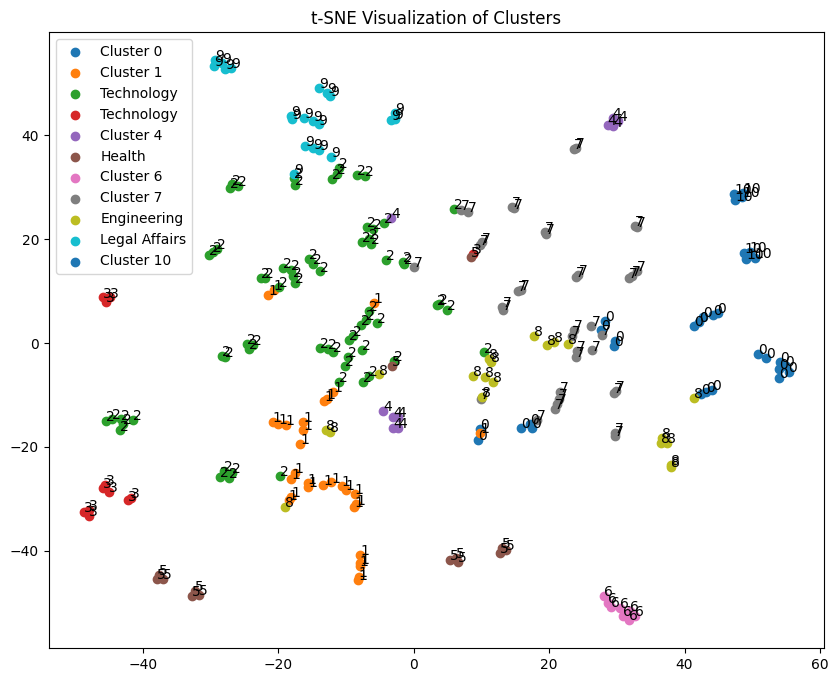

In [45]:
# Import libraries
from sklearn.manifold import TSNE

# Cluster Analysis
clustered_jobs = {}
for cluster_id in range(num_clusters):
    cluster_jobs = [job for i, job in enumerate(job_descriptions) if clusters[i] == cluster_id]
    clustered_jobs[f'Cluster {cluster_id}'] = cluster_jobs
    print(f"Cluster {cluster_id} (Size: {len(cluster_jobs)}):")
    for job in cluster_jobs[:10]:  # Print the first 10 jobs in each cluster
        print(job)

# Cluster Labeling (Example: You can customize this)
# Use cluster characteristics or keywords to label clusters
cluster_labels = {
    2: "Administration",
    5: "Human Resources",
    5: "Health",
    9: "Legal Affairs",
    3: "Technology",
    2: "Technology",
    8: "Engineering"
}

# Visualizing the Clusters with t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=5)
job_descriptions_tsne = tsne.fit_transform(job_description_embeddings)

# Create a figure and plot each cluster with a different color
plt.figure(figsize=(10, 8))
for cluster_id in range(num_clusters):
    cluster_indices = np.where(clusters == cluster_id)
    plt.scatter(
        job_descriptions_tsne[cluster_indices, 0],
        job_descriptions_tsne[cluster_indices, 1],
        label=cluster_labels.get(cluster_id, f'Cluster {cluster_id}')
    )

# Annotate data points with cluster labels
for label, x, y in zip(clusters, job_descriptions_tsne[:, 0], job_descriptions_tsne[:, 1]):
    plt.annotate(label, (x, y))

plt.legend()
plt.title('t-SNE Visualization of Clusters')
plt.show()
